In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

# Task 1

In [ ]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# matrix into vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
original_dim = x_train.shape[1]

## a)

From the lecture we know that ELBO equals

$$ELBO = \mathbb{E}_q \log p(x|z) - KL(q(z|x)||p(z)).$$

Assume that we already know the parameters of the encoder

$$\mathbb{E}_q \log p(x|z) = \mathbb{E}_{\varepsilon} \log p(x|z_{\phi}(\varepsilon, x))$$

Below:

 - `x` - observed vector of pixels (0 and 1)
 - `x_decoded` - $p(1|z_{\phi}(\varepsilon, x)) = p(1|\mu_{\phi}(x) + \Sigma_{\phi}(x)^{1/2}\varepsilon)$, where $\varepsilon$ was generated according to $\mathcal{N}(0, 1)$ - the aposteriori probability of the pixel being $1$ after reparametrization trick
 - $\Sigma_{\phi}(x) = \textrm{diag}(\sigma_{\phi, 1}^2(x), \sigma_{\phi, 2}^2, \ldots, \sigma_{\phi, K}^2)$
 - `z_mean` - $\mu_{\phi}(x) = (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x))$
 - `z_log_var` - $(\log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x))$

 - $q(z|x) = \mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

Input: `x, x_decoded, z_mean, z_log_var`

Output: ELBO

In [ ]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):

    loss_term = tf.reduce_sum(x * tf.math.log(x_decoded + 1e-19) + (1 - x) * tf.math.log(1 - x_decoded + 1e-19), 1)

    KL_term =  0.5 * tf.reduce_sum(-z_log_var + tf.exp(z_log_var) + tf.square(z_mean) - 1, 1)

    return tf.reduce_mean(loss_term - KL_term)

## b)

Next we need to get a sample from $q(z|x)$. We will use a reparametrization trick.

Input: `z_mean, z_log_var`

Output: $\mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # epsilon = sample from standard normal distribution (sample batch observation from dim dimensional normal distribution)
        return # transform epsilon so it becomes from the normal distribution with params z_mean, z_log_var

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## c)

A part of the model that takes input and returns a vector:

$$ (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x), \log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x)) $$

Due to technical reason we will return the above vector and sampled values of $z$ as the output of the encoder (and not as a separate layer).

In [ ]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  200960    ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 256)                  65792     ['dense[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 10)                   2570      ['dense_1[0][0]']             
                                                                                            

In [ ]:
# number of parameters:
(784 + 1)*256, (256 + 1)*256, (256 + 1)*latent_dim

(200960, 65792, 2570)

## d)

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2816      
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 784)               201488    
                                                                 
Total params: 270096 (1.03 MB)
Trainable params: 270096 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## e)

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            total_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 26s 42ms/step - loss: 223.9152
Epoch 2/10
469/469 [==============================] - 18s 38ms/step - loss: 140.0572
Epoch 3/10
469/469 [==============================] - 17s 37ms/step - loss: 126.6463
Epoch 4/10
469/469 [==============================] - 11s 24ms/step - loss: 120.2599
Epoch 5/10
469/469 [==============================] - 8s 16ms/step - loss: 116.7443
Epoch 6/10
469/469 [==============================] - 9s 18ms/step - loss: 114.5053
Epoch 7/10
469/469 [==============================] - 8s 16ms/step - loss: 112.5518
Epoch 8/10
469/469 [==============================] - 8s 18ms/step - loss: 111.2860
Epoch 9/10
469/469 [==============================] - 9s 18ms/step - loss: 110.1787
Epoch 10/10
469/469 [==============================] - 8s 16ms/step - loss: 109.0604


## f)

In [ ]:
# representation in the latent space of observations from test ds
z_test_pred = encoder.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [ ]:
z_test_pred[2].shape

(10000, 10)

In [ ]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
# test_pred = # decoder predictions - we take a vector from the latent space and transform it to be again a picture
test_pred = decoder.predict(z_test_pred[2])

313/313 [==============================] - 1s 2ms/step


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

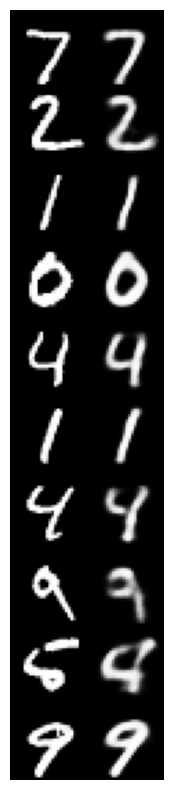

In [ ]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [ ]:
# use z_test_pred

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2)

In [ ]:
z_test_pred_tsne = tsne.fit_transform(z_test_pred[2])

In [ ]:
z_test_pred[2].shape

(10000, 10)

In [ ]:
z_test_pred_tsne.shape

(10000, 2)

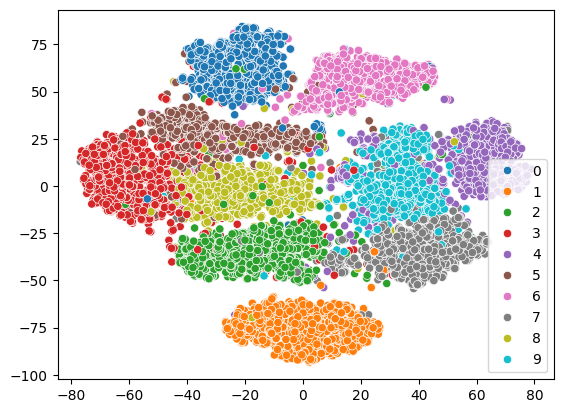

In [ ]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

# Task 3 - homework

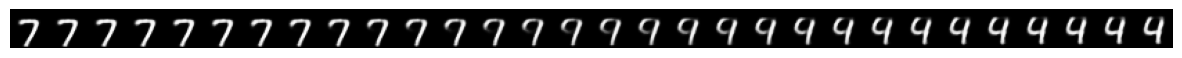

In [ ]:
# transition from one digit to another

a = z_test_pred[2][[0]]
b = z_test_pred[2][[4]]

step = (b - a) / 29

digit_size = (np.sqrt(original_dim)).astype('int')
figure = np.zeros((digit_size, digit_size * 30))

for i in range(30):
  figure[:, i*digit_size:(i+1)*digit_size] = decoder.predict(a, verbose=10).reshape(28, 28)
  a += step

fig = plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='Greys_r')
plt.axis("off")
plt.show()

In [ ]:
# experimenting with enoder's and decoder's architectures
# changing latent dim from 0 to 9

In [ ]:
figure = np.zeros((digit_size * n, digit_size * 10))
digit_size = (np.sqrt(original_dim)).astype('int')

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)

In [ ]:
letant_dim_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]

for idx, latent_dim in enumerate(letant_dim_list):

  encoder_inputs = keras.Input(shape=(original_dim))
  x = Dense(256, activation='relu')(encoder_inputs)
  x = Dense(256, activation='tanh')(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

  latent_inputs = keras.Input(shape=(latent_dim,))
  x = Dense(256, activation='relu')(latent_inputs)
  x = Dense(256, activation='tanh')(x)
  decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
  decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

  vae = VAE(encoder, decoder)
  vae.compile(optimizer=keras.optimizers.Adam())
  vae.fit(x_train, epochs=5, batch_size=128)

  z_test_pred = encoder.predict(x_test)
  decoded = decoder.predict(z_test_pred[2])

  for i in range(10):
      figure[i * digit_size: (i + 1) * digit_size, (idx + 1) * digit_size:(idx + 2) * digit_size] = decoded[i, :].reshape(digit_size, digit_size)

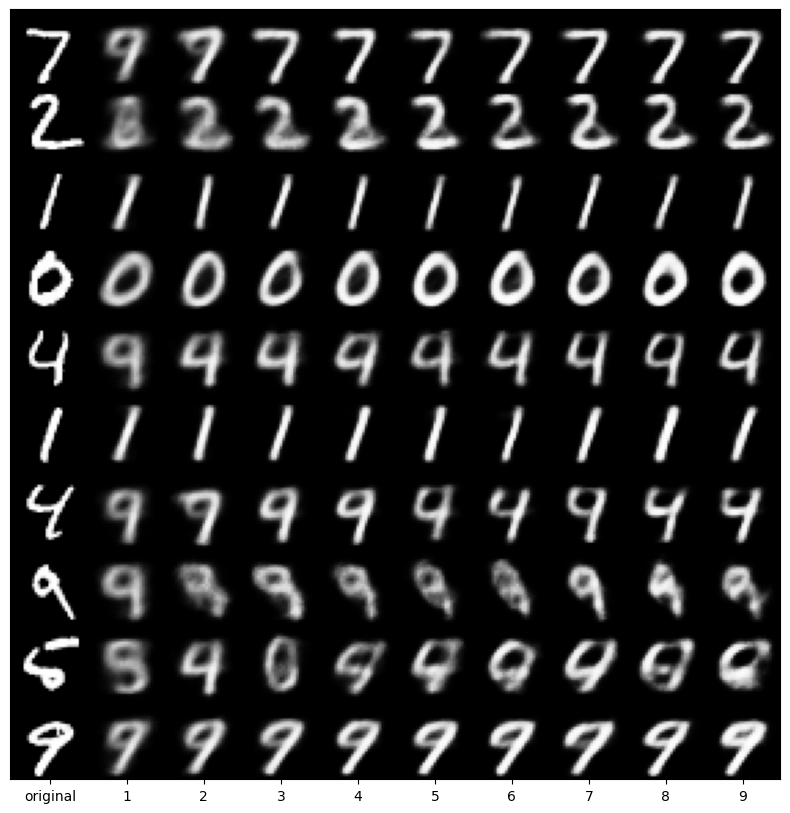

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.gca().get_yaxis().set_visible(False)
plt.gca().set_xticks(ticks=[14 + i * 28 for i in range(10)], labels=["original"] + letant_dim_list)
plt.show()